In [2]:
import problem
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from merge_transformer import MergeTransformer
from sklearn.metrics import mean_squared_error

In [3]:
X_train, y_train = problem.get_train_data('..')
X_train.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_train.loc[:, 'DateOfDeparture'])
y_train = pd.DataFrame(y_train, columns=['Passengers'])

X_test, y_test = problem.get_test_data('..')
X_test.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_test.loc[:, 'DateOfDeparture'])
y_test = pd.DataFrame(y_test, columns=['Passengers'])

In [4]:
Xy_train = X_train.copy()
Xy_train['Passengers'] = y_train

Xy_test = X_test.copy()
Xy_test['Passengers'] = y_test

In [5]:
def _encode_dates(X, drop=False):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    
    if drop:
        X_encoded.drop('DateOfDeparture', inplace=True, axis=1)
        
    return X_encoded
    
date_encoder = FunctionTransformer(_encode_dates)
Xy_train = date_encoder.fit_transform(Xy_train)

<ipython-input-5-231d6e4d65fe>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


In [6]:
Xy_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Passengers,year,month,day,weekday,week,n_days
0,2012-06-19,ORD,DFW,12.875000,9.812647,12.331296,2012,6,19,1,25,15510
1,2012-09-10,LAS,DEN,14.285714,9.466734,10.775182,2012,9,10,0,37,15593
2,2012-10-05,DEN,LAX,10.863636,9.035883,11.083177,2012,10,5,4,40,15618
3,2011-10-09,ATL,ORD,11.480000,7.990202,11.169268,2011,10,9,6,40,15256
4,2012-02-21,DEN,SFO,11.450000,9.517159,11.269364,2012,2,21,1,8,15391


In [7]:
dep_list = Xy_train['Departure'].unique()
arr_list = Xy_train['Arrival'].unique()
routes = list(itertools.product(dep_list, arr_list))

# print(routes)

dict_df = {}
for route in routes:
    df = Xy_train.loc[Xy_train['Arrival'] == route[1]][Xy_train['Departure'] == route[0]]
    if not df.empty:
        dict_df[route] = df

print(len(dict_df))
print(dep_list)

<ipython-input-7-741ae2f63d50>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Xy_train.loc[Xy_train['Arrival'] == route[1]][Xy_train['Departure'] == route[0]]


126
['ORD' 'LAS' 'DEN' 'ATL' 'SFO' 'EWR' 'IAH' 'LAX' 'DFW' 'SEA' 'JFK' 'PHL'
 'MIA' 'DTW' 'BOS' 'MSP' 'CLT' 'MCO' 'PHX' 'LGA']


In [8]:
df_routes = pd.DataFrame(routes, columns=['Departure', 'Arrival'])

In [9]:
df_routes.describe()

,Departure,Arrival
count,400,400
unique,20,20
top,EWR,EWR
freq,20,20


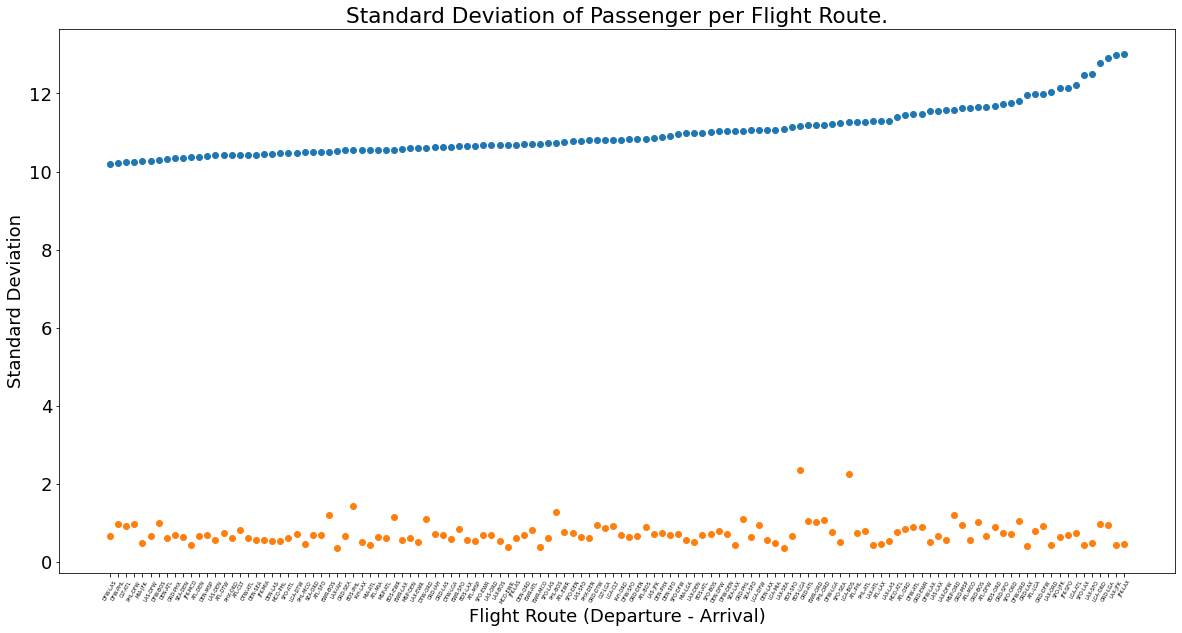

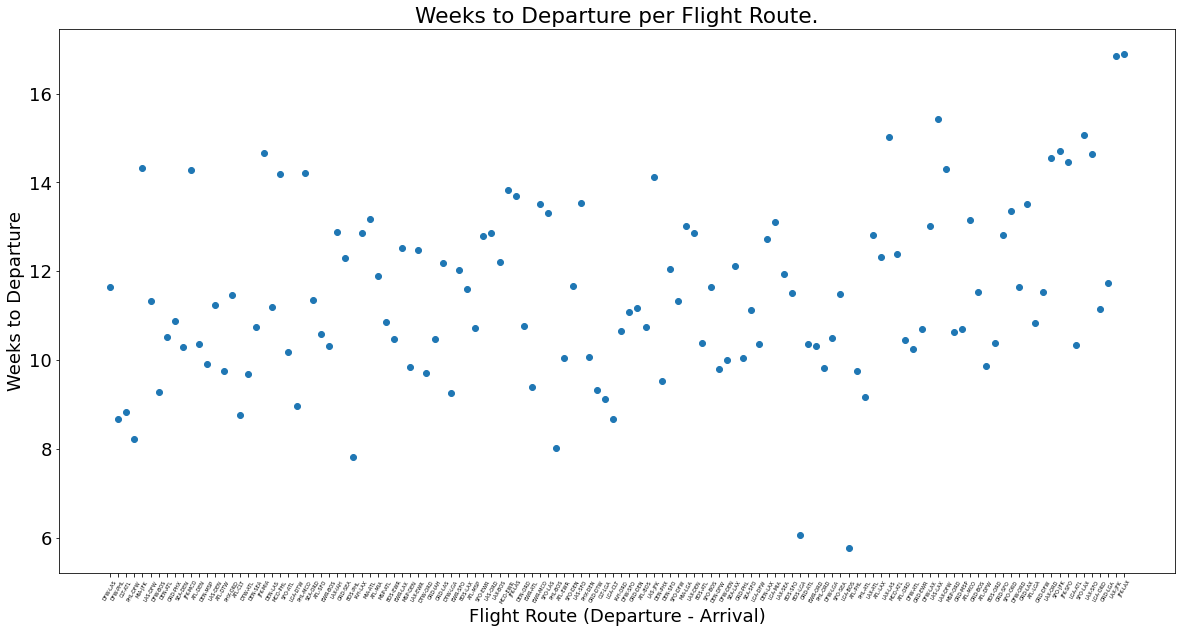

In [10]:
fontsize = 18
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': 5,
          'ytick.labelsize': fontsize,
          'figure.figsize': (20, 10)}
plt.rcParams.update(params)

mean_list = []
std_list = []
routes_list = []
routes_str = []
weeks_to_dep = []

for k, v in dict_df.items():
    dep, arr = k
    std_list.append(v.Passengers.std())
    weeks_to_dep.append(v.WeeksToDeparture.mean())
    routes_list.append(k)
    routes_str.append(dep + "-" + arr)
    mean_list.append(v['Passengers'].mean())

fig = plt.figure(figsize=(20, 10))

dict_means = {'route': routes_str, 'means': mean_list, 'std': std_list, 'weeks_to_dep': weeks_to_dep}
df_means = pd.DataFrame(dict_means)
df_means.sort_values(by='means', inplace=True)
plt.scatter(df_means['route'], df_means['means'])
plt.xticks(df_means['route'], rotation=60)
plt.xlabel("Flight Route (Departure - Arrival)")
plt.ylabel("Mean Passengers")
plt.title("Sorted Mean Number of Passenger per Flight Route.")

plt.scatter(df_means['route'], df_means['std'])
plt.xticks(df_means['route'], rotation=60)
plt.xlabel("Flight Route (Departure - Arrival)")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation of Passenger per Flight Route.")
plt.show()

plt.scatter(df_means['route'], df_means['weeks_to_dep'])
plt.xticks(df_means['route'], rotation=60)
plt.xlabel("Flight Route (Departure - Arrival)")
plt.ylabel("Weeks to Departure")
plt.title("Weeks to Departure per Flight Route.")
plt.show()
fig.savefig("../report/sorted_mean_passengers_eda.png")

In [11]:
Xy_train.describe()

,WeeksToDeparture,std_wtd,Passengers,year,month,day,weekday,week,n_days
count,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000
mean,11.446469,8.617773,10.999048,2011.884071,6.860368,15.508537,2.964165,27.953831,15490.483712
std,2.787140,2.139604,0.993945,0.572206,3.800044,8.875177,2.001616,16.508757,159.694164
min,2.625000,2.160247,3.878108,2011.000000,1.000000,1.000000,0.000000,1.000000,15218.000000
25%,9.523810,7.089538,10.427055,2012.000000,3.000000,8.000000,1.000000,11.000000,15351.000000
50%,11.300000,8.571116,11.013357,2012.000000,8.000000,16.000000,3.000000,31.000000,15490.000000
75%,13.240000,10.140521,11.592888,2012.000000,10.000000,23.000000,5.000000,43.000000,15630.000000
max,23.163265,15.862216,14.007791,2013.000000,12.000000,31.000000,6.000000,52.000000,15769.000000


In [12]:
Xy_test.describe()

,WeeksToDeparture,std_wtd,Passengers
count,2226.000000,2226.000000,2226.000000
mean,11.548317,8.705025,10.992451
std,2.884895,2.169508,1.015452
min,2.750000,2.449490,5.050448
25%,9.527090,7.167768,10.413085
50%,11.347826,8.622248,10.998049
75%,13.333333,10.261717,11.581681
max,21.744186,17.035677,14.224277


In [13]:
print(df_means)

       route      means       std  weeks_to_dep
77   DFW-LAS  10.200343  0.674758     11.649725
79   DFW-PHL  10.222669  0.984592      8.680705
112  CLT-ATL  10.242650  0.922605      8.827146
91   PHL-DFW  10.248289  0.966551      8.227754
96   MIA-JFK  10.270382  0.482779     14.336646
..       ...        ...       ...           ...
65   LAX-SFO  12.493207  0.476516     14.645601
120  LGA-ORD  12.788018  0.979648     11.157277
12   ORD-LGA  12.914158  0.949815     11.743948
69   LAX-JFK  12.994451  0.440701     16.849215
86   JFK-LAX  13.019989  0.475287     16.902797

[126 rows x 4 columns]


In [14]:
df_means.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 77 to 86
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   route         126 non-null    object 
 1   means         126 non-null    float64
 2   std           126 non-null    float64
 3   weeks_to_dep  126 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.9+ KB


In [15]:
df_means[["departure", "arrival"]] = df_means["route"].str.split(r"\b-\b", expand=True)
df_means.head()

,route,means,std,weeks_to_dep,departure,arrival
77,DFW-LAS,10.200343,0.674758,11.649725,DFW,LAS
79,DFW-PHL,10.222669,0.984592,8.680705,DFW,PHL
112,CLT-ATL,10.242650,0.922605,8.827146,CLT,ATL
91,PHL-DFW,10.248289,0.966551,8.227754,PHL,DFW
96,MIA-JFK,10.270382,0.482779,14.336646,MIA,JFK


In [16]:
capacities = pd.read_csv('../data/airports_passengers.csv', sep=';')

In [17]:
capacities

,Rank,Airports (large hubs),IATA,Major city served,State,2019,2018,2017,2016
0,1,Hartsfield-Jackson Atlanta International Airport,ATL,Atlanta,GA,NaN,51866464,50251964,50501858
1,2,Los Angeles International Airport,LAX,Los Angeles,CA,NaN,42626783,41232432,39636042
2,3,O'Hare International Airport,ORD,Chicago,IL,NaN,39874879,38593028,37589899
3,4,Dallas/Fort Worth International Airport,DFW,Dallas,TX,NaN,32800721,31816933,31283579
4,5,Denver International Airport,DEN,Denver,CO,NaN,31363573,29809097,28267394
5,6,John F. Kennedy International Airport,JFK,New York,NY,NaN,30541459,29533154,29239151
6,7,San Francisco International Airport,SFO,San Francisco,CA,NaN,27794154,26900048,25707101
7,8,Seattle-Tacoma International Airport,SEA,Seattle,WA,NaN,24894338,22639124,21887110
8,9,McCarran International Airport,LAS,Las Vegas,NV,NaN,23655285,23364393,22833267
9,10,Orlando International Airport,MCO,Orlando,FL,NaN,23184634,21565448,20283541


In [18]:
merge_transform = MergeTransformer(
    X_ext=capacities, 
    cols_to_rename={'IATA': 'departure', '2016': 'capacity_dep'},
    cols_to_keep=['2016', 'departure'],
    how='left', on=['departure'])
df_means = merge_transform.fit_transform(df_means)

merge_transform = MergeTransformer(
    X_ext=capacities, 
    cols_to_rename={'IATA': 'arrival', '2016': 'capacity_arr'},
    cols_to_keep=['2016', 'arrival'],
    how='left', on=['arrival'])
df_means = merge_transform.fit_transform(df_means)

In [19]:
df_means

,route,means,std,weeks_to_dep,departure,arrival,capacity_dep,capacity_arr
0,DFW-LAS,10.200343,0.674758,11.649725,DFW,LAS,31283579,22833267
1,DFW-PHL,10.222669,0.984592,8.680705,DFW,PHL,31283579,14564419
2,CLT-ATL,10.242650,0.922605,8.827146,CLT,ATL,21511880,50501858
3,PHL-DFW,10.248289,0.966551,8.227754,PHL,DFW,14564419,31283579
4,MIA-JFK,10.270382,0.482779,14.336646,MIA,JFK,20875813,29239151
...,...,...,...,...,...,...,...,...
121,LAX-SFO,12.493207,0.476516,14.645601,LAX,SFO,39636042,25707101
122,LGA-ORD,12.788018,0.979648,11.157277,LGA,ORD,14706123,37589899
123,ORD-LGA,12.914158,0.949815,11.743948,ORD,LGA,37589899,14706123
124,LAX-JFK,12.994451,0.440701,16.849215,LAX,JFK,39636042,29239151


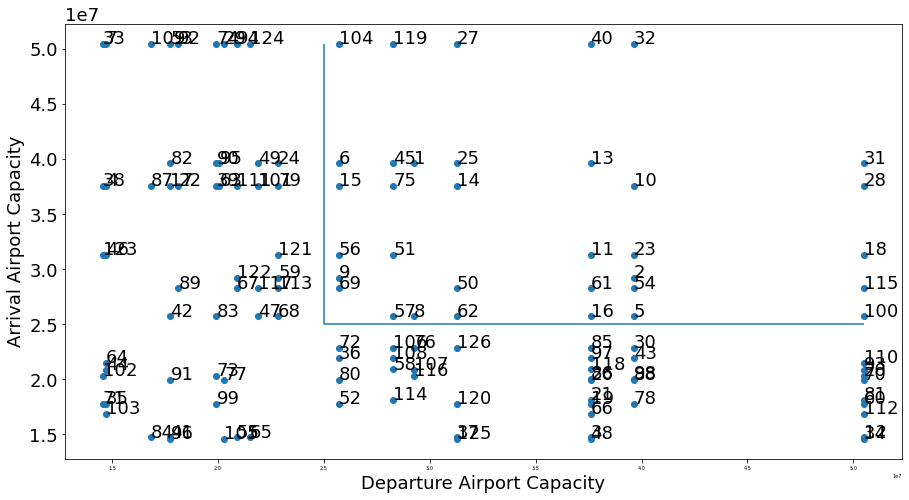

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(df_means['capacity_dep'], df_means['capacity_arr'])
plt.xlabel('Departure Airport Capacity')
plt.ylabel('Arrival Airport Capacity')
plt.hlines(2.5e7, 2.5e7, max(df_means['capacity_dep']))
plt.vlines(2.5e7, 2.5e7, max(df_means['capacity_arr']))
for idx in range(len(df_means['means'])):
    plt.annotate(len(df_means) - idx, xy=(df_means['capacity_dep'][idx], df_means['capacity_arr'][idx]))
plt.show()

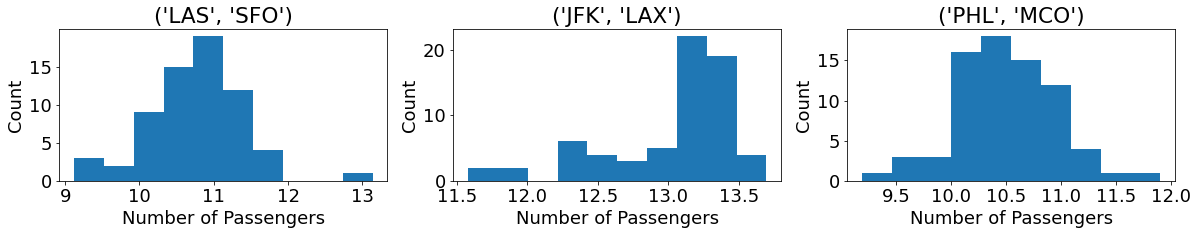

In [21]:
fontsize = 18
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (20, 10)}
plt.rcParams.update(params)

plt.subplots(1, 3, figsize=(20, 140), sharey=True)
i = 1

for k, v in dict_df.items():
    
    if k == ('LAS', 'SFO') or k == ('PHL', 'MCO') or k == ('JFK', 'LAX'):
        plt.subplot(42, 3, i)
        plt.ylabel("Count")
        plt.xlabel("Number of Passengers")
        plt.hist(v['Passengers'])
        plt.title(k)
        i += 1


In [22]:
bos_atl = dict_df[('BOS', 'ATL')]

In [23]:
bos_atl['DateOfDeparture'] = pd.to_datetime(bos_atl['DateOfDeparture'])

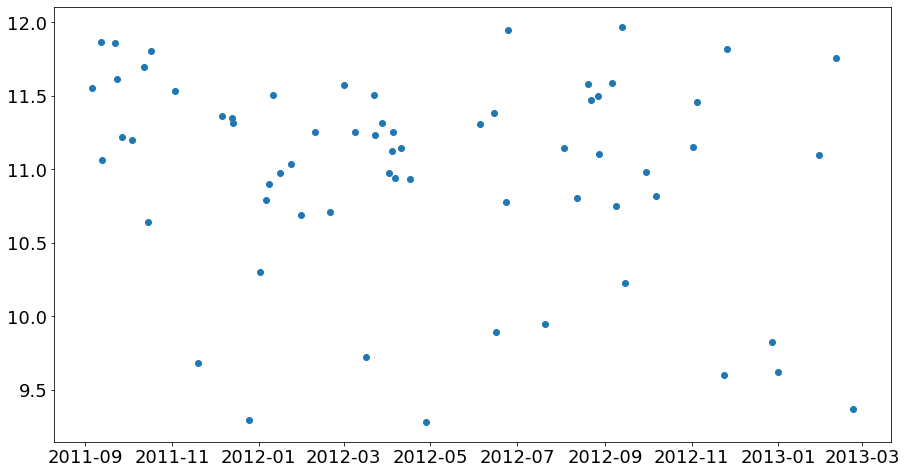

In [24]:
plt.figure(figsize=(15, 8))
plt.scatter(bos_atl['DateOfDeparture'], bos_atl['Passengers'])

In [37]:
def plot_week_day(ax1, df):

    # fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('weekday')
    ax1.set_ylabel('count_flights', color=color)
    ax1.scatter(df['weekday'], df['Passengers'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    bins=7
    color = 'tab:blue'
    ax2.set_ylabel('passengers', color=color)  # we already handled the x-label with ax1
    ax2.hist(df['weekday'], color=color, alpha=0.5, bins=bins, align='center')
    ax2.set_xticks(bins[:-1])
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [26]:
def plot_month(ax1, df):

    # fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('month')
    ax1.set_xticks(np.arange(1,13,1))
    ax1.set_ylabel('count_flights', color=color)
    ax1.scatter(df['month'], df['Passengers'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('passengers', color=color)  # we already handled the x-label with ax1
    ax2.hist(df['month'], color=color, alpha=0.5, bins=12)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [27]:
# fig, ax = plt.subplots(42, 3, figsize=(15, 140), sharex=False, squeeze=False)

# i = 0
# for k, v in dict_df.items():
#     subplot = ax[i // 3, i % 3]
#     plot_week_day(subplot, v)
#     plt.title(k)
#     i += 1
# #     if i == 3:
# #         break
        
# plt.show()

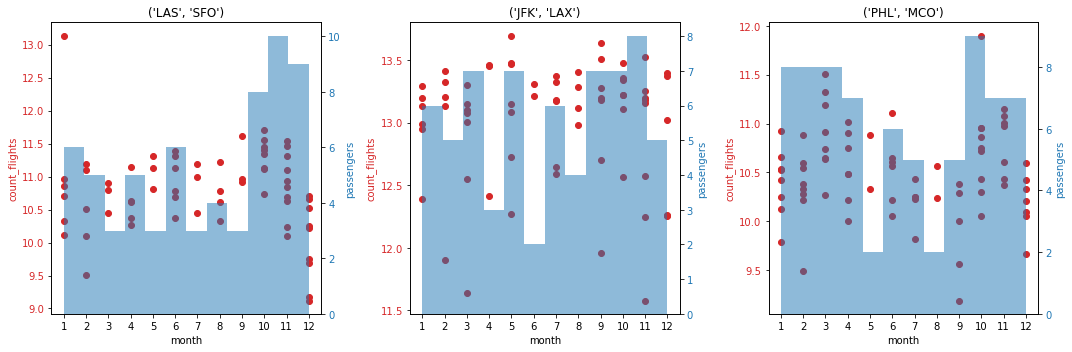

In [38]:
fontsize = 10
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (20, 10)}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False, squeeze=False)

i = 0
for k, v in dict_df.items():
    if k == ('LAS', 'SFO') or k == ('PHL', 'MCO') or k == ('JFK', 'LAX'):
        subplot = ax[i // 3, i % 3]
        plot_month(subplot, v)
        plt.title(k)
        i += 1
#     if i == 3:
#         break
        
plt.show()

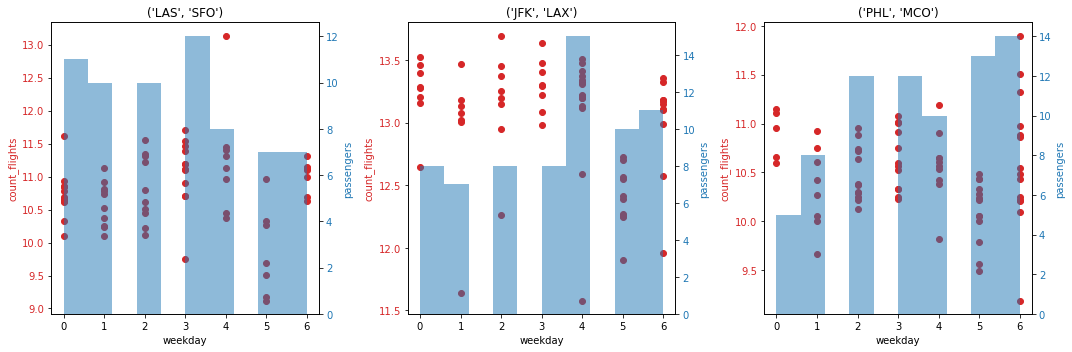

In [43]:
def plot_week_day(ax1, df):

    # fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('weekday')
    ax1.set_ylabel('count_flights', color=color)
    ax1.scatter(df['weekday'], df['Passengers'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('passengers', color=color)  # we already handled the x-label with ax1
    ax2.hist(df['weekday'], color=color, alpha=0.5, align='mid')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

fontsize = 10
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (20, 10)}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False, squeeze=False)

i = 0
for k, v in dict_df.items():
    if k == ('LAS', 'SFO') or k == ('PHL', 'MCO') or k == ('JFK', 'LAX'):
        subplot = ax[i // 3, i % 3]
        plot_week_day(subplot, v)
        plt.title(k)
        i += 1
#     if i == 3:
#         break
        
plt.show()

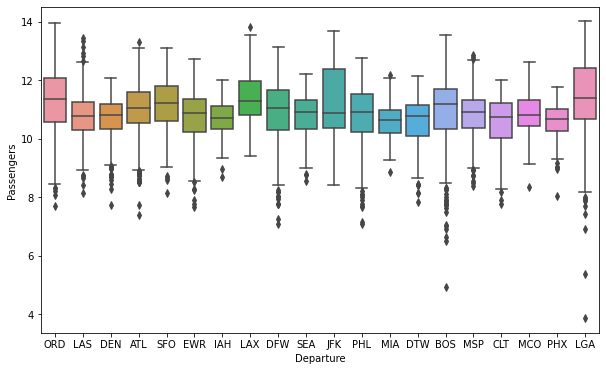

In [48]:
#box plot overallqual/saleprice
var = 'Departure'
data = pd.concat([Xy_train['Passengers'], Xy_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="Passengers", data=Xy_train)

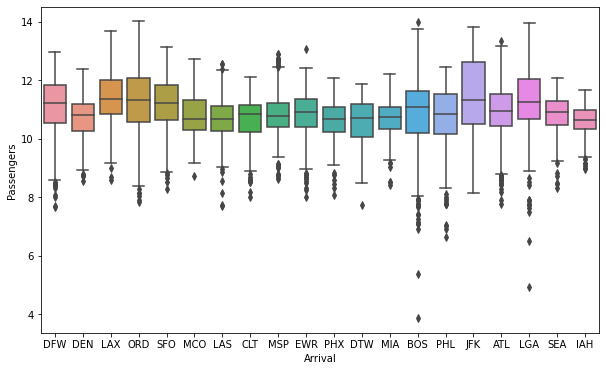

In [52]:
#box plot overallqual/saleprice
var = 'Arrival'
data = pd.concat([Xy_train['Passengers'], Xy_train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="Passengers", data=Xy_train)

<AxesSubplot:>

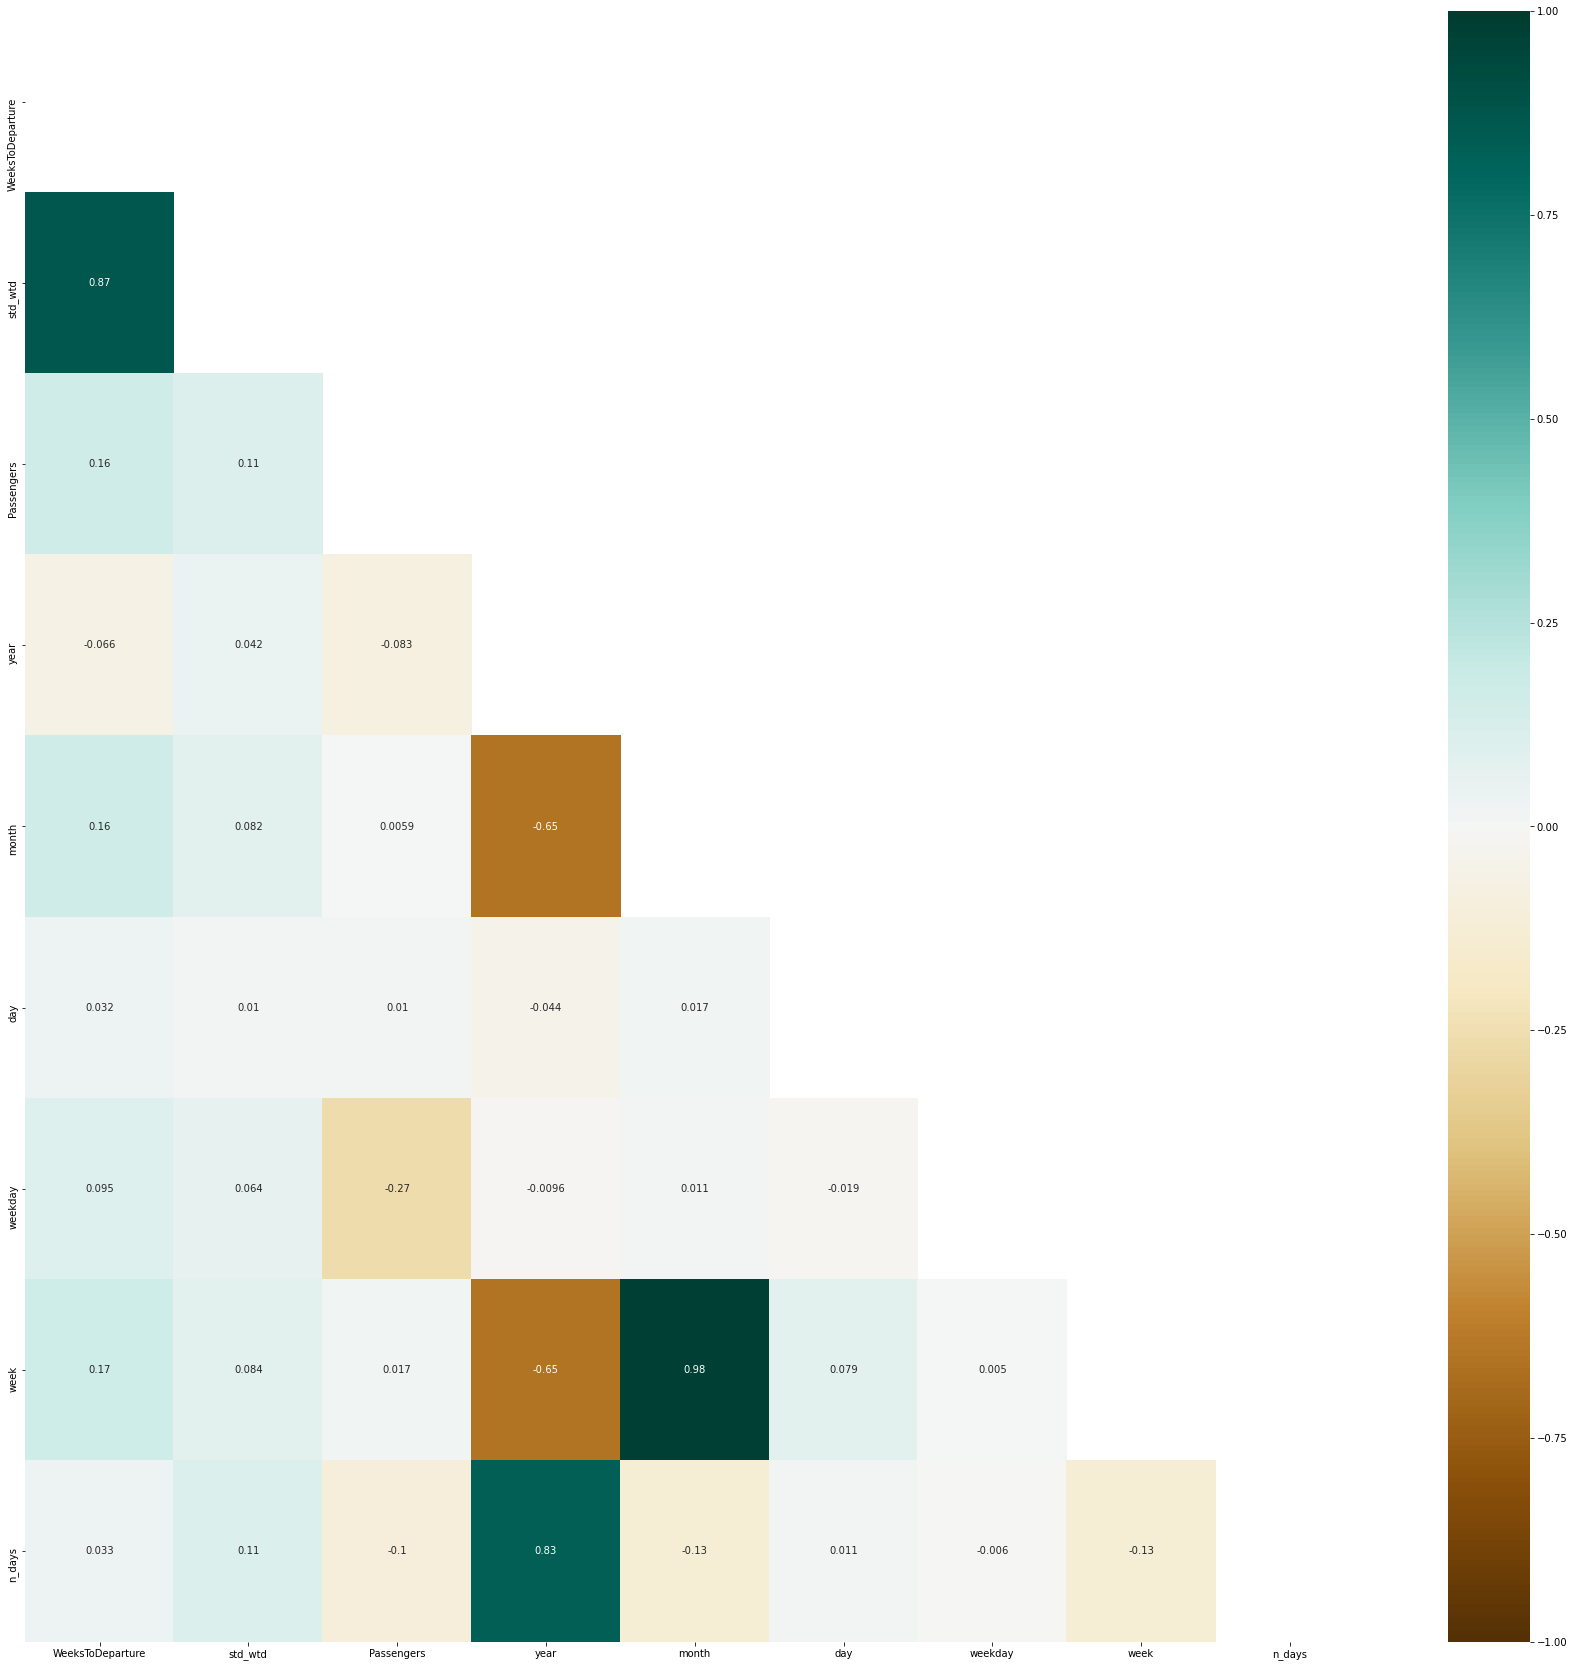

In [44]:
plt.figure(figsize=(30, 30))
Xy_corr = Xy_train.corr()
mask = np.triu(np.ones_like(Xy_corr, dtype=bool))
sns.heatmap(Xy_train.corr(), mask=mask, cmap='BrBG', annot=True, vmin=-1, vmax=1)

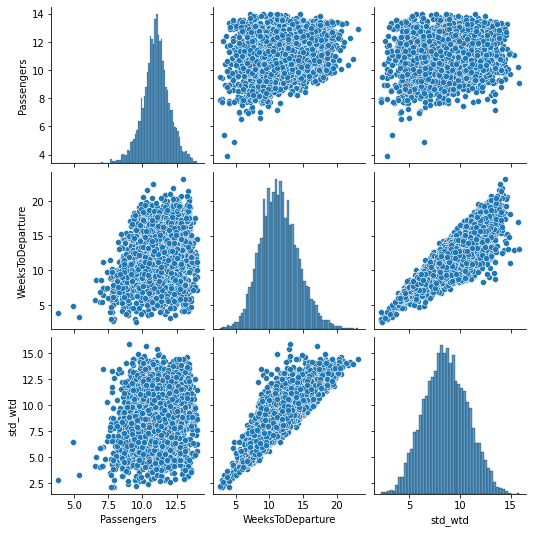

In [54]:
sns.pairplot(Xy_train[['Passengers', 'WeeksToDeparture', 'std_wtd']])

In [55]:
X_train, y_train = problem.get_train_data('..')
X_train.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_train.loc[:, 'DateOfDeparture'])
y_train = pd.DataFrame(y_train, columns=['Passengers'])
Xy_train = X_train.copy()
Xy_train['Passengers'] = y_train
date_encoder = FunctionTransformer(_encode_dates)
Xy_train = date_encoder.fit_transform(Xy_train)

<ipython-input-4-231d6e4d65fe>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


In [56]:
minneapolis = Xy_train.loc[Xy_train['Arrival'] == 'MSP'][Xy_train['Departure'] == 'ATL']
# miami = Xy_train.loc[Xy_train['Arrival'] == 'MIA']
# orlando = Xy_train.loc[Xy_train['Arrival'] == 'MCO']
# las_vegas = Xy_train.loc[Xy_train['Arrival'] == 'LAS']

<ipython-input-56-ea4b8e69a966>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  minneapolis = Xy_train.loc[Xy_train['Arrival'] == 'MSP'][Xy_train['Departure'] == 'ATL']


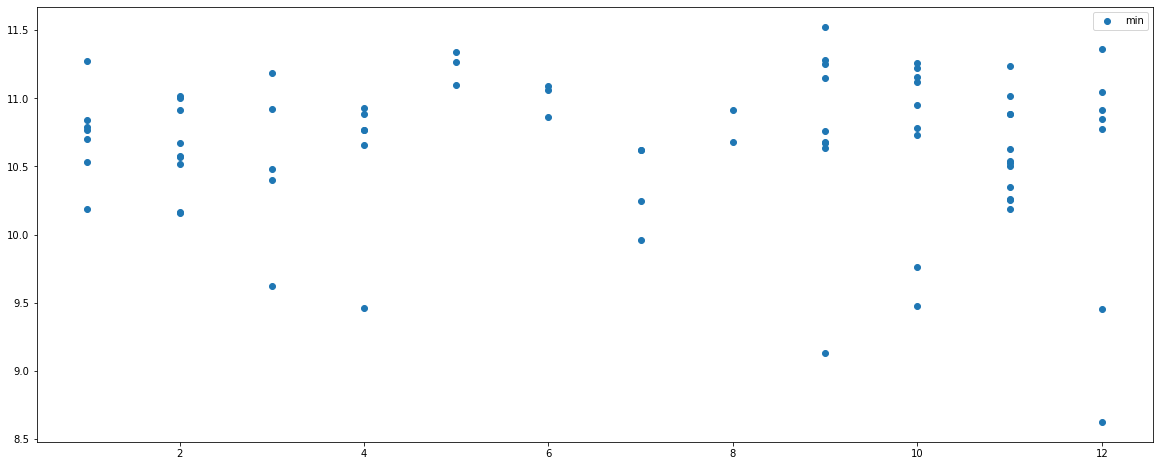

In [57]:
plt.figure(figsize=(20,8))
# plt.scatter(Xy_train['DateOfDeparture'], Xy_train['Passengers'], label='all')
plt.scatter(minneapolis['month'], minneapolis['Passengers'], label='min')
# plt.scatter(minneapolis[['week', 'year']], minneapolis['Passengers'], label='min')
# plt.scatter(minneapolis['week'], minneapolis['Passengers'], label='min')
# plt.scatter(miami['week'], miami['Passengers'], label='miami')
# plt.scatter(orlando['week'], orlando['Passengers'], label='orlando')
# plt.scatter(las_vegas['weekday'], las_vegas['Passengers'], label='orlando')

plt.legend()
plt.show()